# Homework 2: Dijstrka and Ising



#Part 1 - Find your way in Paris


For many of you this is the first year in Paris, one of the most cosmopolitan city in the world. During this homework we will help you building your home-made navigator using the Dijstrka algorithm.

Moreover you will challenge yourself on how to create nice and readble plots using Python.

## Data loading

By running the below cells, you will download all the required data. You can also download them manually and put them in the same folder of the notebook.

In [1]:
#libraries import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

### Map data preparation

Run the cells below to download the data about the map of Paris.

In [ ]:
#this are the data used for plotting the map of Paris
#! wget "https://github.com/Schimmenti/NumPhysENS/raw/master/arrondissements-millesimes0.csv"

In [42]:
# run this code to create a list of the coordinates of the different arrondissements of Paris
arrondis = pd.read_csv("arrondissements-millesimes0.csv", delimiter=";")
arrondis = arrondis[arrondis.Commune.str.contains("PARIS")]
shapes = arrondis.geo_shape
coords = []
arr_names = arrondis.nom_com.values
for shape in shapes:
  temp=json.loads(shape)
  coords.append(np.array(temp['coordinates'])[0,...])
#'coords' is a list of the points making up the perimeter of each arrondissement in Paris
# i.e. coords[0] is a (M,2) matrix with M the number of points
# by using plt.plot(coords[0][:,0],coords[0][:,1]) you can plot the whole arrondissement.
# the important variables here are 'coords' and 'arr_names' i.e. the coordinates and the name of the arrondissement.

([], [])

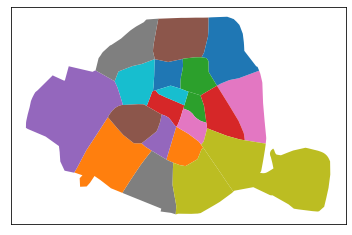

In [3]:
for i in range(len(coords)):
    plt.fill(coords[i][:, 0], coords[i][:, 1])
plt.xticks([])
plt.yticks([])

### Data preparation

Run the two cells below to (i) download the data and (ii) create the networks.  Note that the run time of the second cell is longer and might take one minute.
* Each node of the network is labeled by a unique code and represents a single line station of the Paris transportation network (metro, rer, tram or bus) as of 2018. For example the metro station *Jussieu* is associated to two codes (282 ans 283) one for the metro line 7  and the other for the metro line 10. 

* The dictionary 'net' contains the information about the neighbors of a given node. To find the list of nodes that you can reach from the node 'i' you may use:
```
net[i]
```
* The time (in seconds) taken to travel from the station i to the neighoring station j is given in the nested dictionary 'durations':
```
durations[i][j]
```
This duration represents either the time taken by the public transport (bus, metro...) to connect two consecutive stations or the estimated walking time needed for the change. Note that the network is directed as 'durations[i][j]' can be different from 'durations[j][i]'.


In [ ]:
#this is the data used for plotting the map of Paris
#! wget "https://github.com/Schimmenti/NumPhysENS/raw/master/network_nodes.csv"
#! wget "https://raw.githubusercontent.com/Schimmenti/NumPhysENS/master/network_combined.csv"
#! wget "https://raw.githubusercontent.com/Schimmenti/NumPhysENS/master/network_walk.csv"

In [37]:
net_names = pd.read_csv("network_nodes.csv", delimiter=";")
def search_station(src_string):
  return net_names[net_names.name.str.contains(src_string, case=False)]
def station_name(id):
  return net_names[net_names.stop_I == id].name.values[0]
def station_position(id):
  line = net_names[net_names.stop_I == id]
  return line.lon.values[0], line.lat.values[0]
combined = pd.read_csv("network_combined.csv", delimiter=";")
walk = pd.read_csv("network_walk.csv", delimiter=";")
walk_symm = walk.copy()
walk_symm.from_stop_I = walk.to_stop_I
walk_symm.to_stop_I = walk.from_stop_I
walk = walk.append(walk_symm)
walk = walk.sort_values(by='from_stop_I')
walk = walk.reset_index(drop=True)
final_net = combined.merge(walk, on=['from_stop_I','to_stop_I'], how='outer')
final_net = final_net[["from_stop_I",	"to_stop_I","duration_avg","d_walk"]]
final_duration = np.fmin(final_net.duration_avg,final_net.d_walk)
final_net["duration"] = final_duration
max_idx = max(np.max(final_net["from_stop_I"].values),np.max(final_net["to_stop_I"].values))
min_idx = min(np.min(final_net["from_stop_I"].values),np.min(final_net["to_stop_I"].values))
net ={}
for i in range(min_idx, max_idx+1):
    net[i] = []
durations = {}
for id, g in final_net.groupby('from_stop_I'):
    net[id].extend(list(g["to_stop_I"].values))
    durations[id] = {}
    for _,line in g.iterrows():
      durations[id][line.to_stop_I] = line.duration

## Implementation of the Dijkstra algorithm

Complete the following code to implement the Dijkstra algorithm for this network 

In [4]:
def dijkstra(net, durations, source):
    #dur_src[i] should contain (at the end) the duration (in seconds) that it takes to go from 'source' to 'i'
    dur_src = {}
    #previous_node[i] should contain (at the end) the node preceeding 'i' in the minimal-distance path between 'source' and 'i'
    previous_node = {}
    #this for-loop initializes correctly dur_src and previous_node  
    for k in net.keys():
        dur_src[k] = np.infty
        previous_node[k] = None
    #naturally 'source' has duration '0' from itself
    dur_src[source] = 0

    temp = [n for n in net.keys()]
    while len(temp) > 0:
        dist = {u: dur_src[u] for u in temp}
        min_node = min(dist, key=dist.get)
    
        temp.remove(min_node)
    
        for nei in net[min_node]:
            test = dur_src[min_node] + durations[min_node][nei]
            if test < dur_src[nei]:
                dur_src[nei] = test
                previous_node[nei] = min_node
            
    return dur_src, previous_node   

We give you an hint for such implementation. Use the same trick we used to construct the clusters in the Wolff algorithm. In order to explore the network more efficiently it is better to pop the elements in 'border' starting from the oldest one (e.g. the one that we added first during the exploration). To do this simply use the function .pop(0) instead of .pop(). Namely:

```
border = [source]
  while(len(border)>0):
    next_node = border.pop(0)
```

## Question 1

After the Friday lesson you have been invited to a party held at 358 rue de Pyrénées. The closest metro station is *Pyrénées* (with code 146). From 24 rue Lhomond the closest metro station is *Place Monge - Jardin des Plantes* (with code 42). Compute the minimal duration of the trip to reach the party.


In [2]:
source = 42
target = 146

dur_src, previous_node = dijkstra(net, durations, 42)
min_duration = dur_src[target]
print("Time :", min_duration)

NameError: name 'dijkstra' is not defined

## Question 2

Reconstruct the full path listing all the intermediate stations and the time (in minutes) taken to reach them. The final result should look like:
```
Station: 42 Time: 0
Station: yyyy Time: zzzz
(omissis)
Station: 146 Time: xxxx
```

In [ ]:
def build_path(source, target, dur_src, previous_node):
    path = [target]
    inter = [0]
    while path[-1] != source:
        path.append(previous_node[path[-1]])
    path.reverse()
    
    for i in range(len(path) - 1):
        inter.append(dur_src[path[i + 1]] - dur_src[path[i]])
    return path, inter

path, inter = build_path(source, target, dur_src, previous_node)
for i, station in enumerate(path):
    print("Station :", station, station_name(station), "Time :", inter[i])

## Question 3
* Represent your results on the map of Paris and indicate the name of each station in the path.

* To do this we provide two functions:
  1.   A function 'station_name(id)' that, given the code of the station, returns its name:
    ```
    station_name(42)
    ```
  2.   A function 'station_position(id)' that, given the code of the station, returns its GPS coordinates as a tuple i.e. (x,y):
  ```
    station_position(42)
    ```
* We provide also a code below that generates an empty map. All the data needed to do so have been downloaded in section 'Data loading'. Modify the code in order to answer the question.

In [ ]:
#the variables coords and arr_names have been generated in the 'Data loading/Map data preparation' section.
fig, ax = plt.subplots(figsize=(25,15))
for idx,coord in enumerate(coords):
    #plots the perimeter
    plt.plot(coord[:,0],coord[:,1])
    #centroid of the arrondissement 
    x_avg = np.mean(coord[:,0])
    y_avg = np.mean(coord[:,1])
    #adds a text and a bullet at the centroid of the arr.
    plt.text(x_avg,y_avg,arr_names[idx])

    plt.scatter(x_avg,y_avg)

station_coords = []
for station in path:
    station_coords.append(station_position(station))
    plt.text(station_coords[-1][0], station_coords[-1][1], station_name(station), fontsize='small')
tab = np.array(station_coords)
plt.plot(tab[:, 0], tab[:, 1], '-o', color='black')
plt.xticks([])
plt.yticks([])
plt.show()

## Question 4

Unfortunately a big social protest is taking place in Jussieu and the metro stations with codes 282 and 283 are closed. Find an alternative itinerary to reach the party. Provide its duration and map.

### Hint
Since Jussieu is closed for the whole day, the duration of the connections to and from Jussieu become one day longer (i.e. 86400 seconds). In order to avoid Jussieu modify the nested-dictionary 'durations' and add at the appropriate spots this time delay.


In [ ]:
def take_more_time(dur, delay):
    dur = {x: delay + dur[x] for x in dur}
    return dur

durations_bis = durations.copy()
durations_bis[282] = take_more_time(durations_bis[282], 86400)
durations_bis[283] = take_more_time(durations_bis[283], 86400)

dur_src_b, previous_node_b = dijkstra(net, durations_bis, source)

In [ ]:
path_b, inter = build_path(source, target, dur_src_b, previous_node_b)
for i, station in enumerate(path_b):
    print("Station :", station, station_name(station), "Time :", inter[i])
    
#the variables coords and arr_names have been generated in the 'Data loading/Map data preparation' section.
fig, ax = plt.subplots(figsize=(25,15))
for idx,coord in enumerate(coords):
    #plots the perimeter
    plt.plot(coord[:,0],coord[:,1])
    #centroid of the arrondissement 
    x_avg = np.mean(coord[:,0])
    y_avg = np.mean(coord[:,1])
    #adds a text and a bullet at the centroid of the arr.
    plt.text(x_avg,y_avg,arr_names[idx])

    plt.scatter(x_avg,y_avg)

station_coords = []
for station in path:
    station_coords.append(station_position(station))
    plt.text(station_coords[-1][0], station_coords[-1][1], station_name(station), fontsize='small')
tab = np.array(station_coords)
plt.plot(tab[:, 0], tab[:, 1], '--o', color='black', label="Previous path")

station_coords = []
for station in path_b:
    station_coords.append(station_position(station))
    plt.text(station_coords[-1][0], station_coords[-1][1], station_name(station), fontsize='small')
tab = np.array(station_coords)
plt.plot(tab[:, 0], tab[:, 1], '-o', color='black', label="New path")

plt.legend()
plt.xticks([])
plt.yticks([])
plt.show()

# Part 2 - Further exploration of the Ising model

In this second part, you will be interested in the two-dimensional Ising model.
As a reminder, the Ising model describes a set of spins sitting on the sites
of a given lattice. You will consider the **periodic** two-dimensional square
lattice with $N = L \times L$ sites. The spin sitting on the site $j$ is described by
a variable $\sigma_j = \pm 1$. The energy for
a given configuration $\{ \sigma \}$ of spins is

$$
E(\{\sigma\}) = -J\sum_{\langle ij \rangle} \sigma_i \sigma_j
$$

where $\langle i j \rangle$ indicates that $i$ and $j$ are
nearest-neighbors on the lattice. In the following, you will consider the
ferromagnetic case $J>0$ and use $J=1$ as the unit of energy.
The Ising model has a phase transition at the critical temperature

$$
T_c = \frac{2}{\ln(1+\sqrt{2})} = 2.269185\ldots
$$

## The Glauber algorithm

During the lecture, you have studied three different Monte Carlo algorithms for the Ising model. Here, you will investigate one more: the Glauber algorithm.
Just like the heat-bath it is also a rejection-free
algorithm. The algorithm follows these steps:

1. Pick a random site $i$ on the lattice

2. Flip the spin $\sigma_i$ on site $i$ to $-\sigma_i$ with probability:

   $$
    P^\mathrm{flip}_i = \frac{1}{1 + \exp(\beta \, 2 J \sigma_i h_i)}
   $$
   
   where $h_i$ is the molecular field on the site $i$:
   
   $$
   h_i = \sum_{j \, \in \, \text{neighbors of $i$}} \sigma_j
   $$
   
3. Go back to step 1.

### Question 5

Prove that the Glauber algorithm leads to a sampling of the configurations that follows the Boltzmann distribution.

### Answer 
Glauber dynamics follows de

#### Answer 5
Noting $\pi(\sigma_i)$ the probability of being in configuration $\Sigma_i$, $\pi_{i \rightarrow j}$ to move from $i$ to $j$ and $A_{i \rightarrow j}$ the acceptance of the move.
From detailled balance condition, one gets: $\frac{\pi(\Sigma_i)}{\pi(\Sigma_j)} = \frac{\pi_{j \rightarrow i}A_{i \rightarrow j}}{\pi_{i \rightarrow j} A_{i \rightarrow j}}$. Since here the fliped site is chosen randomly, $\pi_{i \rightarrow j} = \pi_{j \rightarrow i}$. And acceptance rate is given by Glauber's dynamics : $A_{i \rightarrow j} = \frac{\exp(-\beta(E_j - E_i)}{1 + \exp(-\beta(E_j - E_i)}$. (because $E_j - E_i = - J \sigma_i h_i$ if $i$ is the chosen site).
Thus, $\frac{\pi(\Sigma_i)}{\pi(\Sigma_j)} = \exp(-\beta(E_i - E_j)$, indicating that the configuration sampling follows Botlzmann distribution (i.e that $\pi(\Sigma_i) \propto \exp(-\beta E_i)$). $\square$

### Question 6

Implement the Glauber algorithm and compare your results to those
  obtained with the Wolff algorithm.
  More specifically, use both algorithms to compute: the absolute value of the magnetization,
  the specific heat, the energy and the susceptibility as a function of temperature.
  Use a $6 \times 6$ lattice and 10 temperatures in the range $[0.5, 4.0]$.
  
  The function that implements the Glauber algorithm can have the signature
  ```python
def glauber(config, T)
    # your code
  ```
  where `config` is a spin configuration to be modified by the Glauber algorithm and `T`
  is the temperature. Just like for the heat bath, let the function apply a total of
  $N = L \times L$ proposal moves.
  
  When running
  the Wolff algorithm, use the implementation below. It is an improved version of the algorithm
  that we have used in the lecture that runs a bit faster:

  ```python
def wolff(config, T):
    
    # pick a site
    L = config.shape[0]
    i, j = np.random.randint(L, size=2)
    border = set([(i,j)])
    
    # inclusion probability
    beta = 1 / T
    p = 1.0 - np.exp(-2.0 * beta)
    direction = config[i,j]

    # grow the cluster
    while border:
        i, j = border.pop()
        neighbors = [ ((i+1)%L, j), ((i-1)%L, j), (i, (j+1)%L), (i, (j-1)%L) ]
        for u, v in neighbors:
            if config[u,v] == direction and np.random.rand() < p:
                border.update([(u,v)])
                
        config[i,j] *= -1
   ```

#### Answer 6

_A code as well as 4 plots showing a comparison between the algorithms are expected._

In [6]:
def neighbours(i, j, L):
    return np.array([((i+1)%L, j), ((i-1)%L, j), (i, (j+1)%L), (i, (j-1)%L)])


def wolff(config, T):

    # pick a site
    L = config.shape[0]
    i, j = np.random.randint(L, size=2)
    border = set([(i,j)])

    # inclusion probability
    beta = 1 / T
    p = 1.0 - np.exp(-2.0 * beta)
    direction = config[i,j]

    # grow the cluster
    while border:
        i, j = border.pop()
        neighbors = [ ((i+1)%L, j), ((i-1)%L, j), (i, (j+1)%L), (i, (j-1)%L) ]
        for u, v in neighbors:
            if config[u,v] == direction and np.random.rand() < p:
                border.update([(u,v)])

        config[i,j] *= -1

def glauber(config, T):

    #pick a site
    L = config.shape[0]
    i, j = np.random.randint(L, size=2)
    h = 0
    
    # neighbour field
    n = neighbours(i, j, L)
    h = np.sum(config[n[:, 0], n[:, 1]])
        
    p = 1 / (1 + np.exp(2 * config[i, j] * h / T))
    if np.random.rand() < p:
        config[i, j] *= -1


def compute_energy(config):
    L = len(config)
    E = 0
    for i in range(len(config)):
        for j in range(len(config)):
            nei = neighbours(i, j, L)
            E -= np.sum(config[nei[:, 0], nei[:, 1]] * config[i, j])
    return E / 2


def compute_magnetization(config):
    return np.sum(config)


def monte_carlo(L, T, n_steps, method):
    e_temp = np.zeros(n_steps, dtype=float)
    m_temp = np.zeros(n_steps, dtype=float)
    config =np.random.choice([-1,1], size=(L,L))

    for k in range(n_steps):
        method(config, T)
        e_temp[k] = compute_energy(config)
        m_temp[k] = compute_magnetization(config)
    
    # get average and error bar
    en = np.average(e_temp) / L**2
    mag = np.average(np.abs(m_temp)) / L**2
    cv = np.var(e_temp) / T**2 / L**2
    chi = np.var(np.abs(m_temp)) / T / L**2

    return en, mag, cv, chi


L = 6

T = np.linspace(0.5, 4.0, 10)
steps = 5000

energy = np.zeros_like(T)
magnetization = np.zeros_like(T)
cv = np.zeros_like(T)
chi = np.zeros_like(T)

energy_g = np.zeros_like(T)
magnetization_g = np.zeros_like(T)
cv_g = np.zeros_like(T)
chi_g = np.zeros_like(T)

for i, temp in enumerate(T):
    print('Computing temperature', temp)
    energy[i], magnetization[i], cv[i], chi[i] = monte_carlo(L, temp, steps, wolff)
    energy_g[i], magnetization_g[i], cv_g[i], chi_g[i] = monte_carlo(L, temp, steps, glauber)


Computing temperature 0.5
Computing temperature 0.8888888888888888
Computing temperature 1.2777777777777777
Computing temperature 1.6666666666666667
Computing temperature 2.0555555555555554
Computing temperature 2.4444444444444446
Computing temperature 2.8333333333333335
Computing temperature 3.2222222222222223
Computing temperature 3.611111111111111
Computing temperature 4.0


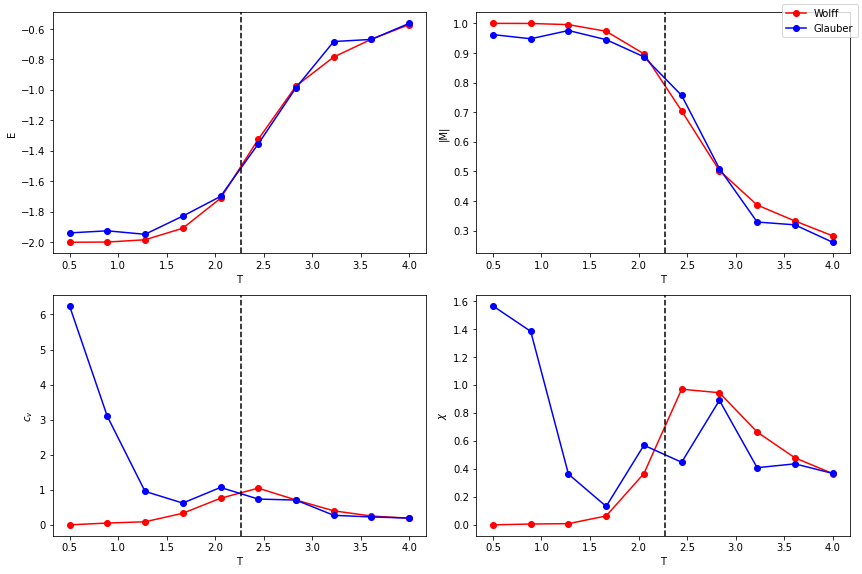

In [4]:
T_c = 2 / np.log(1 + np.sqrt(2))

fig, axs = plt.subplots(2, 2, figsize=(12, 8), tight_layout=True)
axs[0, 0].plot(T, energy, '-o', color='r', label="Wolff")
axs[0, 0].plot(T, energy_g, '-o', color='b', label="Glauber")

axs[0, 0].axvline(T_c, linestyle='--', color='black')
axs[0, 0].set_xlabel("T")
axs[0, 0].set_ylabel('E')

axs[0, 1].plot(T, magnetization, '-o', color='r')
axs[0, 1].plot(T, magnetization_g, '-o', color='b')

axs[0, 1].axvline(T_c, linestyle='--', c='black')
axs[0, 1].set_xlabel("T")
axs[0, 1].set_ylabel("|M|")

axs[1, 0].plot(T, cv, '-o', color='r')
axs[1, 0].plot(T, cv_g, '-o', color='b')
axs[1, 0].axvline(T_c, linestyle='--', c='black')
axs[1, 0].set_xlabel("T")
axs[1, 0].set_ylabel("$c_v$")

axs[1, 1].plot(T, chi, '-o', color='r')
axs[1, 1].plot(T, chi_g, '-o', color='b')
axs[1, 1].axvline(T_c, linestyle='--', c='black')
axs[1, 1].set_xlabel("T")
axs[1, 1].set_ylabel("$\chi$")
fig.legend()

### Answer
One show that the two methods gives significantly results below the critical temperature. Susceptibility and specific heat are very differents. This should come from the sampling dynamics. Indeed, in wolff algorithm, the micro-state space is explored with higher jumps since entire cluster are flipped. In the glauber dynamics, there is only local changes. When the temperature is highly below the critical temperature, the flipping probability is near 0 for points inside clusters. Only spins at the borders can be flipped. Thus, the exploration of micro-state space takes more iterations. We should need more that $N$ move then.

## Cluster size histogram

In this section, you will investigate the distribution of cluster sizes in the Wolff cluster
algorithm. In particular, you will study what are the cluster sizes that are sampled
in different regimes of the Ising model: low temperature, high temperature and at the critical temperature $T_c$.

### Question 7

Make a small modification to the `wolff` function given above so that it returns
  the size of the cluster that was flipped. Then, create histograms that display the distribution
  of cluster sizes that are flipped during the Monte Carlo sampling. Compute these histograms
  for 3 temperatures: $T = 0.9 T_c, T_c, 1.1 T_c$ for a system of size $32 \times 32$.
  Discuss the results.

In [5]:
def wolff_cluster(config, T):

    # pick a site
    L = config.shape[0]
    i, j = np.random.randint(L, size=2)
    border = set([(i,j)])
    size = 1
    # inclusion probability
    beta = 1 / T
    p = 1.0 - np.exp(-2.0 * beta)
    direction = config[i,j]

    # grow the cluster
    while border:
        i, j = border.pop()
        neighbors = [ ((i+1)%L, j), ((i-1)%L, j), (i, (j+1)%L), (i, (j-1)%L) ]
        for u, v in neighbors:
            size += 1
            if config[u,v] == direction and np.random.rand() < p:
                border.update([(u,v)])

        config[i,j] *= -1
    return size

L = 32
config = np.random.choice([-1, 1], size=(L, L))

T_c = 2 / np.log(1 + np.sqrt(2))
T = np.array([0.9 * T_c, T_c, 1.1 * T_c])
steps = 5000
cluster_size = np.zeros((T.shape[0], steps), dtype = int)

for i, temp in enumerate(T):
    print("Computing temperature ...", temp)
    for s in range(steps):
        cluster_size[i, s] = wolff_cluster(config, temp)
    

Computing temperature ... 2.04226678279172
Computing temperature ... 2.269185314213022
Computing temperature ... 2.4961038456343245


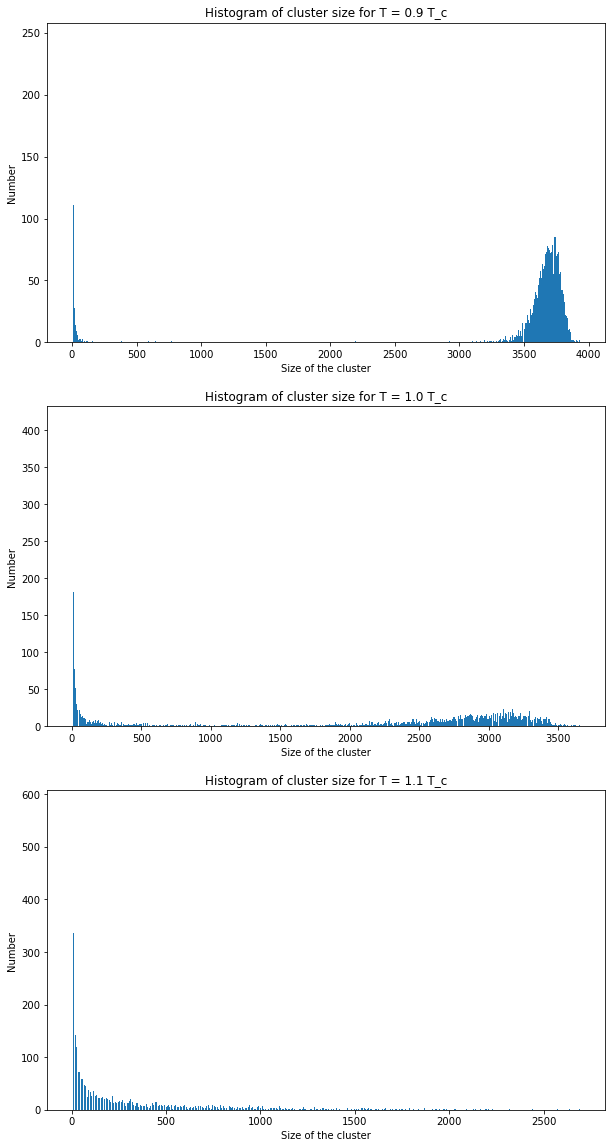

In [6]:
fig, axs = plt.subplots(3, 1, figsize=(10, 20))
titles = [0.9, 1.0, 1.1]
for i in range(len(T)):
    axs[i].hist(cluster_size[i, :], bins = 1000)
    axs[i].set_xlabel("Size of the cluster")
    axs[i].set_ylabel("Number")
    axs[i].set_title("Histogram of cluster size for T = %1.1f T_c" %titles[i])
    

#### Answer 7

We see that as we go to $T_c$ cluster size is decreasing. At low temperatures, very large clusters dominate (wich can be related to the cluster "physically" observed in the system). And when we cross the transition, there is almost no "big" cluster (size $\geq 1000$), so that wolff dynamics becomes not significantly different from local sampling (Metropolis). Moreover, the cluster size in wolff dynamics can help us to investigate what is going on in the system (here, a phase transition).

## Spin-spin correlations

In this last section, you will compute and discuss the spin-spin correlation function.
It is defined by the following average

$$
  C(r) = \langle \sigma_i \; \sigma_{i+r} \rangle
$$

This function measures how the spin at site $i$ and the spin at site $i+r$ are correlated.
In the following, you will focus on the case where $r$ is a vector along the horizontal
axis. In other words, the site $i$ and the site $i+r$ are on the same row. The correlation
function $C(r)$ does not depend on $i$ because of the translational symmetry of the lattice.
On an infinite lattice and not too far from the critical temperature, it can be shown that the correlation function has the following
behavior at large $r$:
  
$$
 C(r) \sim A \frac{\exp(-r / \xi)}{(r/\xi)^\eta} + S
$$

where $\xi$ is the correlation length and $A, S$ are constants. Onsager has shown that
the critical exponent $\eta = 1/4$.

### Question 8

Write a function that computes the correlation function $C(r)$ using the Wolff cluster
  Monte Carlo algorithm on a $32 \times 32$ lattice.
  Compute $C(r)$ at two temperatures: $T = 0.8 T_c$ and $T = 1.2 T_c$. Discuss the qualitative differences
  between these results (using plots of $C(r)$ in both cases).

In [8]:
def correlation(config):
    L = config.shape[0]
    corr = np.zeros(L, dtype=float)
    for r in range(L):
        mean = np.mean(np.roll(config, r, axis= 1).flatten() * config.flatten())
        corr[r] = mean
    return corr

L = 32
T = np.array([0.8 * T_c, 1.2 * T_c], dtype=float)
steps = 5000
corr = np.zeros((2, steps, L), dtype=float)
config_1 = np.random.choice([-1, 1], size=(L, L))
config_2 = np.random.choice([-1, 1], size=(L, L))

for s in range(steps):
    wolff(config_1, T[0])
    corr[0, s] = correlation(config_1)
    wolff(config_2, T[1])
    corr[1, s] = correlation(config_2)

Text(0.5, 1.0, '$C(r)$ for $T$ = 1.2 $T_c$')

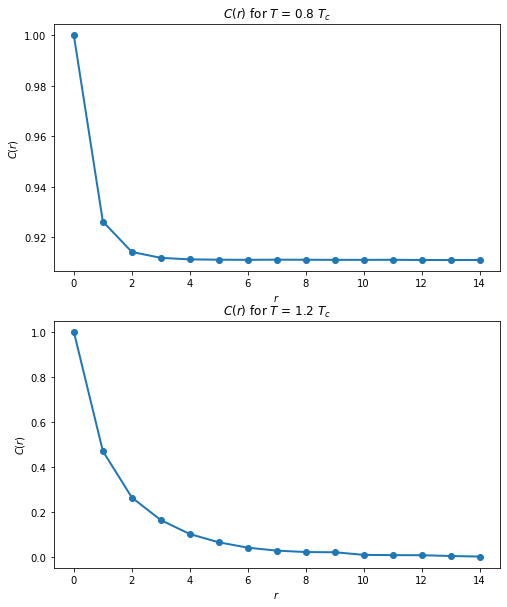

In [17]:
fig, axs = plt.subplots(2, 1, figsize=(8, 10))
axs[0].plot(np.mean(corr[0][1000:].T, axis=1)[:15], lw=2, marker='o')
axs[0].set_xlabel("$r$")
axs[0].set_ylabel("$C(r)$")
axs[0].set_title("$C(r)$ for $T$ = 0.8 $T_c$")
axs[1].plot(np.mean(corr[1][1000:].T, axis=1)[:15], lw=2, marker='o')
axs[1].set_xlabel("$r$")
axs[1].set_ylabel("$C(r)$")
axs[1].set_title("$C(r)$ for $T$ = 1.2 $T_c$")

#### Answer 8

We see that above $T_c$ the correlation decays to zero as an exponential $C(r) \approx \exp(- r/ \xi)$ with $\xi \approx 3$. Below the critical temperature, correlation function decays to a non-zero constant.

### Question 9

Compute the correlation function $C(r)$ for 10 temperatures in the range
  $[T_c - 0.3, T_c + 0.3]$. Fit these correlation functions with a function of the form
  
  $$
    f_\mathrm{fit}(r) = A \frac{\exp(-r / \xi)}{(r/\xi)^\eta} + S
  $$

  where $A$, $S$, $\eta$ and $\xi$ are fitting parameters. Note that even though we know that $\eta = 1/4$
  from the Onsager solution, we will not assume we know that value and you should use $\eta$ as one of the
  fitting parameters. Create plots that show $C(r)$ and its fits.
  
#### Hints
  
  - Because we work with finite lattices with periodic boundary conditions, be careful
    to only use *half* of the data in $C(r)$.
    
  - The fitting function is in principle only valid for large $r$. In practice, you can
    just **ignore the first point** (at $r=0$) of the data in the fit.
      
  - You can use `scipy.optimize` to do the fits. Here is an example of how it works:
  
    ```python
    import scipy.optimize
    
    # fit function
    def fit_function(x, a, b, c):
      return # some function of (x,a,b,c)

    # data obtained by Monte Carlo
    x_values = ...
    y_values = ...
    
    # do the fit
    a, b, c = scipy.optimize.curve_fit(fit_function, x_values, y_values, bounds=[0,20])[0]
    
    ```
   
    where we have specified that the fit should only consider values for $a,b,c$ in $[0,20]$.

In [9]:
import scipy.optimize

def fit_function(x, a, b, c, s):
    return a * np.exp(-x / b) / (x / b) ** c + s

def interpolate(x_v, y_v):
    a, b, c, s = scipy.optimize.curve_fit(fit_function, x_v, y_v, bounds=(0, 20))[0]
    return a, b, c, s

T_c = 2 / np.log(1 + np.sqrt(2))
L = 32
steps = 5000
T = np.linspace(T_c - 0.3, T_c + 0.3, 10)
corr = np.zeros((T.shape[0], L), dtype=float)
temp_corr = np.zeros((steps, L), dtype=float)
config = np.random.choice([-1, 1], size=(L, L))

for i, temp in enumerate(T):
    print('Computing T =', temp)
    for s in range(steps):
        wolff(config, temp)
        temp_corr[s] = correlation(config)
    corr[i] = np.mean(temp_corr[1000:].T, axis=1)

Computing T = 1.969185314213022
Computing T = 2.0358519808796887
Computing T = 2.102518647546355
Computing T = 2.169185314213022
Computing T = 2.235851980879689
Computing T = 2.3025186475463553
Computing T = 2.3691853142130217
Computing T = 2.4358519808796886
Computing T = 2.5025186475463554
Computing T = 2.569185314213022


T =  1.969185314213022 A= 0.04619970858951683 Xi= 1.5718656746809272 Eta =  0.8065296504032795 S =  0.8486286645918326
T =  2.0358519808796887 A= 0.04928355241105911 Xi= 2.012495657624925 Eta =  0.7938373527141539 S =  0.8064242283512718
T =  2.102518647546355 A= 0.0703138217109256 Xi= 2.2646660705963098 Eta =  0.6581949711417128 S =  0.7513230271356578
T =  2.169185314213022 A= 0.06956605657379533 Xi= 3.615851546153432 Eta =  0.6557831995688104 S =  0.6708332783032909
T =  2.235851980879689 A= 0.10603575601032462 Xi= 5.3520913897638565 Eta =  0.5201203853546282 S =  0.535665632600568
T =  2.3025186475463553 A= 0.2253122499863585 Xi= 5.940140423612932 Eta =  0.35072524935550287 S =  0.3346266461537619
T =  2.3691853142130217 A= 0.3356294921700671 Xi= 6.232791612486606 Eta =  0.30450009405231193 S =  0.12834663861272208
T =  2.4358519808796886 A= 0.3774717638393325 Xi= 5.566688268446222 Eta =  0.3130970865140342 S =  0.04494018762105717
T =  2.5025186475463554 A= 0.4310513186710706 Xi= 

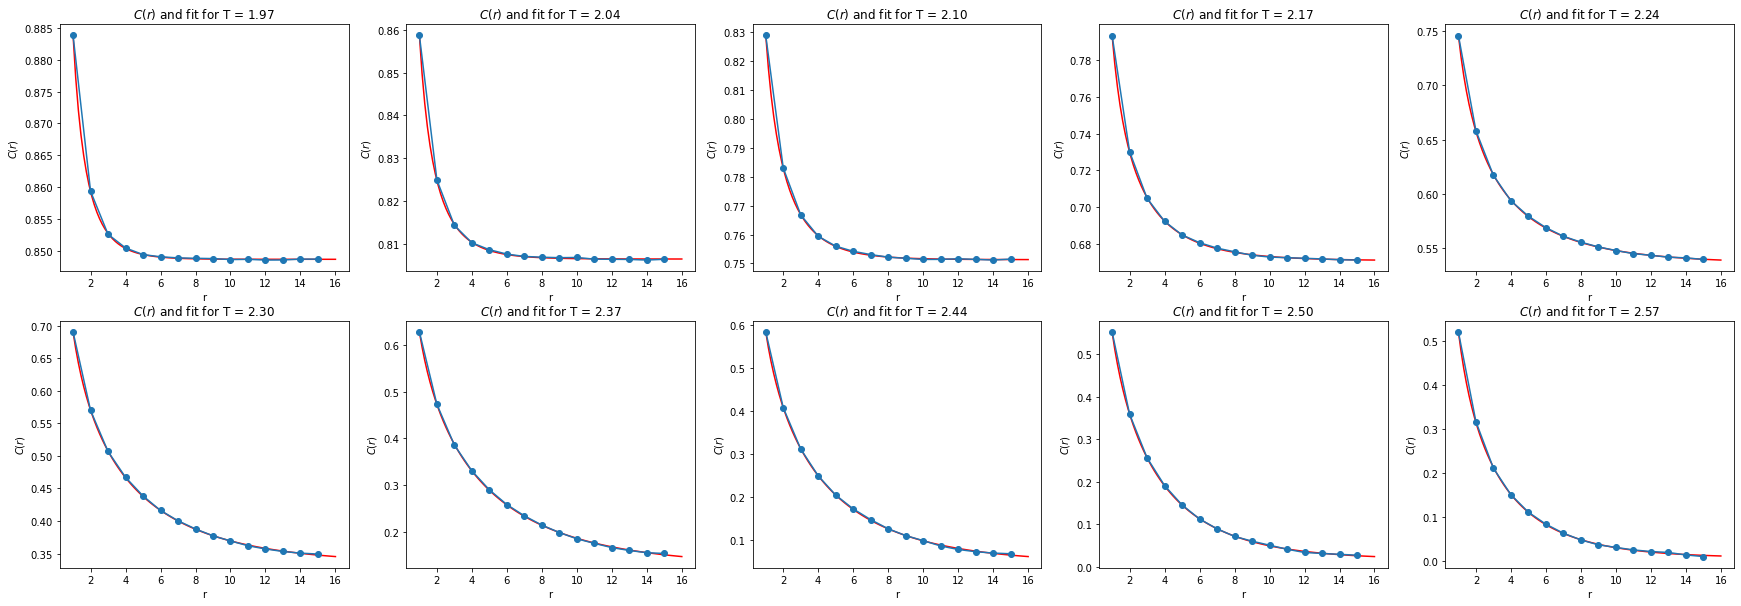

In [16]:
x_values = np.arange(L)[1: int(L / 2)]
x_plot = np.linspace(1, 16, 100)
a = np.zeros(T.shape[0])
b = np.zeros(T.shape[0])
c = np.zeros(T.shape[0])
s = np.zeros(T.shape[0])
count = 0
j = 0
k = 0
fig, axs = plt.subplots(2, 5, figsize=(30, 10))
for i in range(T.shape[0]):
    count += 1
    k = i
    if count > 5:
        j = 1
        k = i - 5
    a[i], b[i], c[i], s[i] = interpolate(x_values, corr[i][1: int(L / 2)])
    print("T = ", T[i], "A=", a[i], "Xi=", b[i], "Eta = ", c[i], "S = ", s[i])
    axs[j, k].plot(x_plot, fit_function(x_plot, a[i], b[i], c[i], s[i]), 'r')
    axs[j, k].plot(x_values, corr[i][1 : int(L / 2)], '-o')
    axs[j, k].set_xlabel('r')
    axs[j, k].set_ylabel("$C(r)$")
    axs[j, k].set_title('$C(r)$ and fit for T = %1.2f'%T[i])


#### Answer 9

_A code together with 10 plots is expected._


 ### Question 10
 
Discuss the behavior of the fitting parameters $\xi, \eta, S$ in connection with their physical meaning.

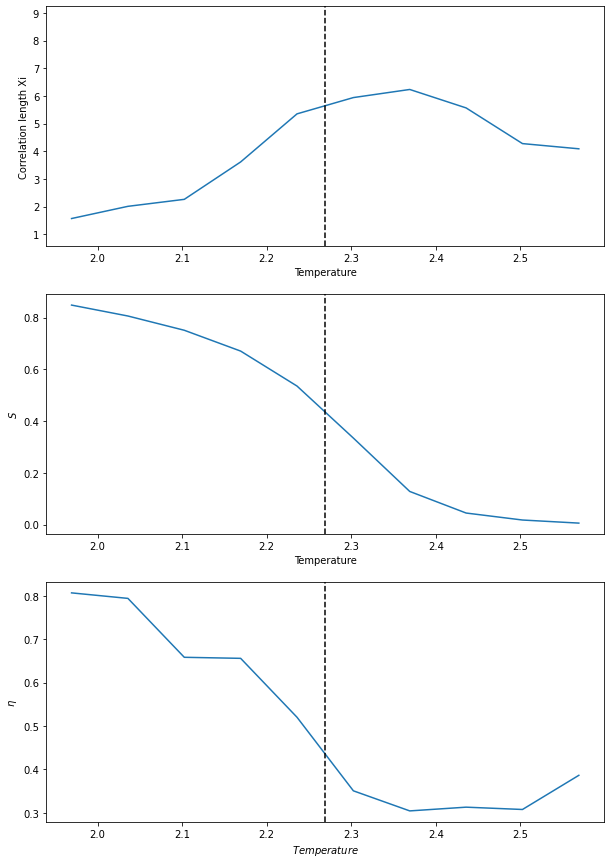

In [65]:
fig, axs  = plt.subplots(3, 1, figsize=(10, 15))
axs[0].plot(T, b)
axs[0].set_xlabel("Temperature")
axs[0].set_ylabel("Correlation length Xi")
axs[0].axvline(T_c, color='black', ls='--')
axs[0].set_ylim(np.min(b) - 1, np.max(b) + 3)

axs[1].plot(T, s)
axs[1].set_xlabel('Temperature')
axs[1].set_ylabel('$S$')
axs[1].axvline(T_c, color='black', ls='--')

axs[2].plot(T, c)
axs[2].set_xlabel('$Temperature$')
axs[2].set_ylabel('$\eta$')
axs[2].axvline(T_c, color='black', ls='--')

#### Answer 10

Correlation length: the correlation length is finite below the transition, in the ordered state, then should diverge at the transition. In our simulation, we see an increasing of this parameter at the transition. Finally, it decays to zero with the temperature because of thermal agitation.

S (Asymptotic value of correlation function): In the ordered phase, one can see that S is finite and non-zero, indicating the presence of clusters. In the disordered phase, only short-range interactions subsit due to thermal agitation. Thus, S is expected to decrease with the temperature as observed.

Eta (Critical parameter): $\eta$ is defined as the critical point such that $C(r) \propto 1/ r ^{\eta}$. Here we are quite far from the expected value $1/4$ (got $\approx 0.4$).